# Baseline Model Evaluation
- on the augmented PaHaW dataset
- exclude pretrained weights
- **goal**: compare baseline results with models pretrained using transfer learning and trained using supervised contrastive learning

In [1]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import scikit-learn utilities
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Import PyTorch utilities
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet50

# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except ImportError:
    print("Google Colab not detected, skipping drive mounting.")

# Set up plotting styles
sns.set()
plt.style.use('ggplot')

Google Colab not detected, skipping drive mounting.


## Data Preprocessing and Feature Extraction using ResNet50

In [2]:
# Preprocessing steps for the input images:
# 1. Resize the image to a larger size.
# 2. Crop the center region to the target size.
# 3. Convert the image to a tensor.
# 4. Normalize the image using mean and standard deviation values for each channel.
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the ResNet50 model for feature extraction.
# Use pre-trained weights from the ImageNet dataset.
# Replace the fully connected (fc) layer with an identity layer to get raw features.
resnet = models.resnet50(weights=None)
resnet.fc = torch.nn.Identity()
resnet.eval()  # Set the model to evaluation mode.

# Move the model to GPU if available for faster processing.
if torch.cuda.is_available():
    resnet.cuda()

# Function to load image data from a directory and create a DataLoader object.
# The images are loaded using a specified transform (preprocess).
def load_data(directory):
    dataset = datasets.ImageFolder(directory, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
    return dataloader

# Function to extract features from images using the ResNet model.
# Takes a DataLoader object and returns features and labels.
def extract_features(dataloader):
    features = []  # List to store extracted features.
    labels = []  # List to store corresponding labels.
    with torch.no_grad():  # Disable gradient computation for efficient inference.
        for inputs, label_batch in dataloader:
            # Move data to GPU if available.
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            # Extract features and move them to the CPU.
            feature_batch = resnet(inputs)
            features.extend(feature_batch.cpu().numpy())
            labels.extend(label_batch.numpy())
    return features, labels

In [3]:
# Load data from the directory containing labeled images.
dataloader = load_data('C:\\Users\\Zhongyao Wang\\Desktop\\complete_data')
# Extract features using the ResNet model.
features, labels = extract_features(dataloader)

# Split the features based on label values.
pd_features = [feature for feature, label in zip(features, labels) if label == 0]
health_features = [feature for feature, label in zip(features, labels) if label == 1]

# Print dataset information for verification.
print(dataloader.dataset.classes)
print(len(health_features))
print(len(features))

['test', 'train']
346
432


## Model Evaluation using Logistic Regression

1. Accuracy: 0.5747
2. Precision: 0.6667
3. Recall: 0.7869
4. F1 Score: 0.7218


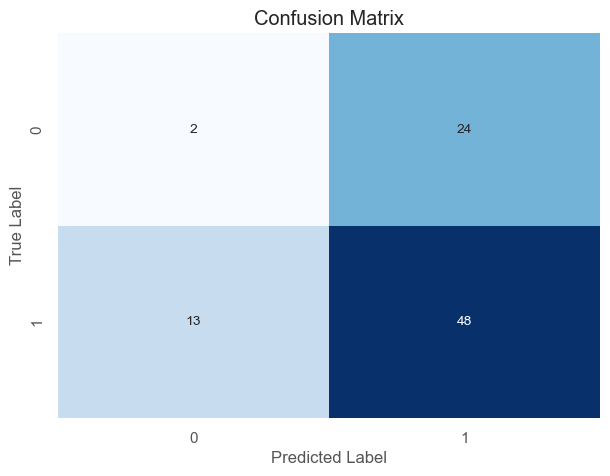

C:\Users\Zhongyao Wang\AppData\Local\Temp\ipykernel_12680\2901580291.py:59: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  interp_tpr = interp(base_fpr, fpr, tpr)


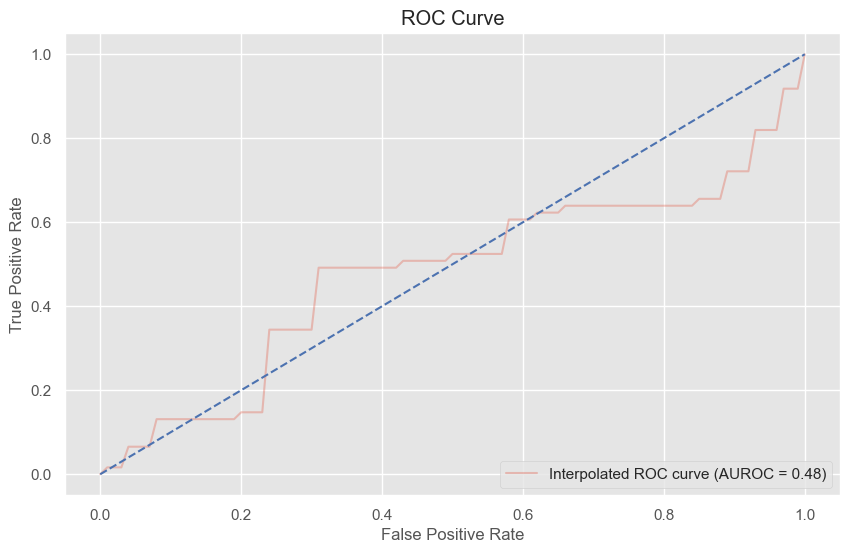

5. AUROC Value: 0.4767


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
from scipy import interp
from numpy import linspace

# Convert lists to NumPy arrays for feature-label splitting.
features = np.array(features)
labels = np.array(labels)

# Split the dataset into training and testing sets.
# Using an 80-20 split and a fixed random state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Initialize and train the logistic regression model.
# Using `max_iter` to ensure convergence.
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Predict the labels and probabilities for the test set.
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate performance metrics: Accuracy, Precision, Recall, and F1 Score.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics for the test set.
print(f'1. Accuracy: {accuracy:.4f}')
print(f'2. Precision: {precision:.4f}')
print(f'3. Recall: {recall:.4f}')
print(f'4. F1 Score: {f1:.4f}')

# Generate and display the Confusion Matrix as a heatmap.
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate the Area Under the ROC Curve (AUROC).
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Compute the ROC curve and interpolate it for smoother plotting.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
base_fpr = linspace(0, 1, 101)
interp_tpr = interp(base_fpr, fpr, tpr)
interp_tpr[0] = 0.0  # Ensure the curve starts at (0, 0).

# Plot the interpolated ROC curve.
plt.figure(figsize=(10, 6))
plt.plot(base_fpr, interp_tpr, alpha=0.3, label='Interpolated ROC curve (AUROC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'b--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print the calculated AUROC value.
print(f'5. AUROC Value: {roc_auc:.4f}')

## Model Evaluation using ResNet

Epoch 1, Loss: 2.0227933283040276
Epoch 2, Loss: 1.1872716930142502
Epoch 3, Loss: 1.4026844321838063
Epoch 4, Loss: 0.7689140887567024
Epoch 5, Loss: 0.7686125901634752
Epoch 6, Loss: 1.276021120861546
Epoch 7, Loss: 0.82126706429147
Epoch 8, Loss: 0.680161719911614
Epoch 9, Loss: 0.9293251226136954
Epoch 10, Loss: 0.6705939022866988
Epoch 11, Loss: 0.6411425005002268
Epoch 12, Loss: 1.0157179148685744
Epoch 13, Loss: 0.5172512673441021
Epoch 14, Loss: 0.6747213808883881
Epoch 15, Loss: 0.5836230083957485
Epoch 16, Loss: 0.7910058842115533
Epoch 17, Loss: 0.5716257991119363
Epoch 18, Loss: 0.9271415660971369
Epoch 19, Loss: 0.6906749049479934
Epoch 20, Loss: 0.5629256390150648
Epoch 21, Loss: 0.5198574992132255
Epoch 22, Loss: 0.5554880422232913
Epoch 23, Loss: 0.4810256191504077
Epoch 24, Loss: 0.536748855068996
Epoch 25, Loss: 0.5140829077044009
Epoch 26, Loss: 0.6571704254474492
Epoch 27, Loss: 0.6619071875827323
Epoch 28, Loss: 0.41647168896268066
Epoch 29, Loss: 0.358930866078784

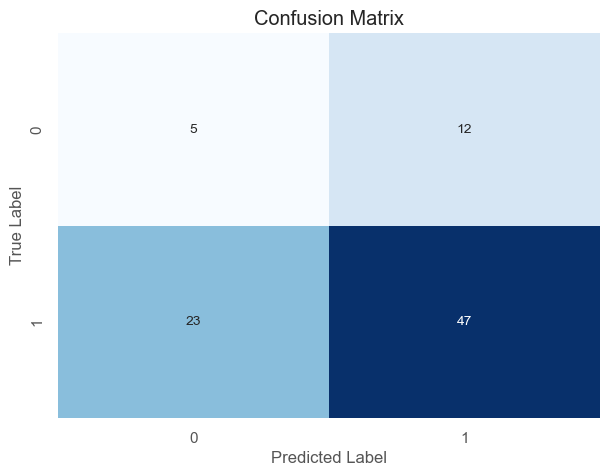

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


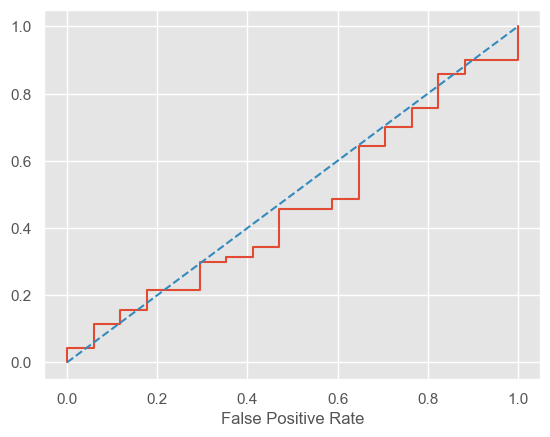

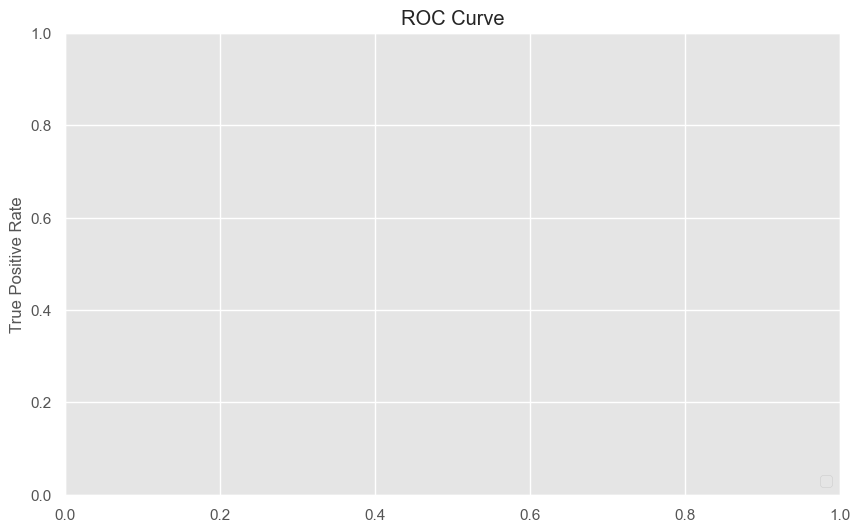

5. AUROC Value: 0.4622


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(51)

# Data preprocessing steps:
# 1. Resize image to 256 pixels on the shorter side.
# 2. Crop the center region to 224x224 pixels.
# 3. Convert the image to a tensor.
# 4. Normalize with mean and standard deviation.
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset using ImageFolder.
dataset_path = 'C:\\Users\\Zhongyao Wang\\Desktop\\complete_data'
dataset = datasets.ImageFolder(dataset_path, transform=preprocess)

# Split the dataset into training and validation sets using indices.
# Maintain the same label distribution using `stratify`.
train_indices, val_indices = train_test_split(
    np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=dataset.targets
)
train_dataset = Subset(dataset, indices=train_indices)
val_dataset = Subset(dataset, indices=val_indices)

# Create DataLoader objects for training and validation datasets.
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model setup:
# Initialize the ResNet50 model without pre-trained weights.
# Replace the last layer with a new fully connected layer (2 classes).
resnet = models.resnet50(weights=None)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

# Move the model to the GPU if available.
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    print("cuda")

# Loss and optimizer setup:
# Use CrossEntropyLoss for classification and SGD with momentum for optimization.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Training loop:
num_epochs = 50
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Move inputs and labels to the GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Zero the parameter gradients before each update.
        optimizer.zero_grad()

        # Forward pass and calculate the loss.
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        # Backward pass to compute gradients and update parameters.
        loss.backward()
        optimizer.step()

        # Accumulate the loss for the current epoch.
        running_loss += loss.item()

    # Print the average loss for this epoch.
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}')

print('Finished Training')

# Function to evaluate the model's performance on a given DataLoader.
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode.
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():  # Disable gradient computation for evaluation.
        for inputs, labels in dataloader:
            # Move inputs to the GPU if available.
            if torch.cuda.is_available():
                inputs = inputs.cuda()
            # Perform a forward pass through the model to get predictions.
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class.
            scores = torch.softmax(outputs, dim=1)[:, 1]  # Extract scores.

            # Store true labels, predicted labels, and scores for analysis.
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(scores.cpu().numpy())

    return y_true, y_pred, y_scores

# Evaluate the trained ResNet model using the validation DataLoader.
y_true, y_pred, y_scores = evaluate_model(resnet, val_dataloader)

# Calculate performance metrics: accuracy, precision, recall, F1 score, and ROC AUC.
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_scores)

# Print evaluation metrics to console.
print(f'1. Accuracy: {accuracy:.4f}')
print(f'2. Precision: {precision:.4f}')
print(f'3. Recall: {recall:.4f}')
print(f'4. F1 Score: {f1:.4f}')

# Generate and visualize the Confusion Matrix.
conf_matrix = confusion_matrix(y_true, y_pred)      
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate and plot the ROC curve.
fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.plot(fpr, tpr, label=f'ROC curve (AUROC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.figure(figsize=(10, 6))
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print the calculated AUROC value.
print(f'5. AUROC Value: {roc_auc:.4f}')


In [9]:
!pip install efficientnet_pytorch


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16465 sha256=2becc04124680301a5cdc5cdd1b109be22e16d4e2a0db6858d5ad86859d10030
  Stored in directory: c:\users\zhongyao wang\appdata\local\pip\cache\wheels\8b\6f\9b\231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch


Epoch 1, Loss: 0.532454362203335
Epoch 2, Loss: 0.5323467271766443
Epoch 3, Loss: 0.5201325562150999
Epoch 4, Loss: 0.5175252520832522
Epoch 5, Loss: 0.517495209800786
Epoch 6, Loss: 0.5009283530472339
Epoch 7, Loss: 0.4936023734766862
Epoch 8, Loss: 0.48064918644811916
Epoch 9, Loss: 0.4781442037944136
Epoch 10, Loss: 0.43104535307007275
Epoch 11, Loss: 0.4194478330941036
Epoch 12, Loss: 0.5162555344145874
Epoch 13, Loss: 0.39254460543736647
Epoch 14, Loss: 0.3320303276695054
Epoch 15, Loss: 0.3952347404997924
Epoch 16, Loss: 0.30349360808901404
Epoch 17, Loss: 0.29414849539940385
Epoch 18, Loss: 0.3196434698056901
Epoch 19, Loss: 0.28505329391651457
Epoch 20, Loss: 0.34618958441176634
Epoch 21, Loss: 0.24911158484802848
Epoch 22, Loss: 0.23964719480738558
Epoch 23, Loss: 0.2226234067060139
Epoch 24, Loss: 0.20600424813984455
Epoch 25, Loss: 0.2391601454188255
Epoch 26, Loss: 0.21134025390773756
Epoch 27, Loss: 0.21310002431701655
Epoch 28, Loss: 0.16390330035603423
Epoch 29, Loss: 0.

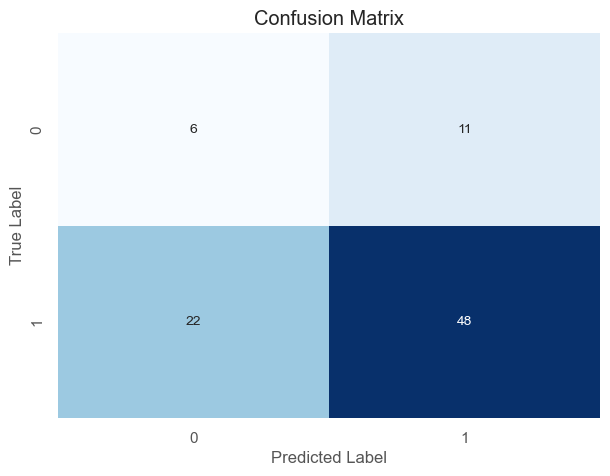

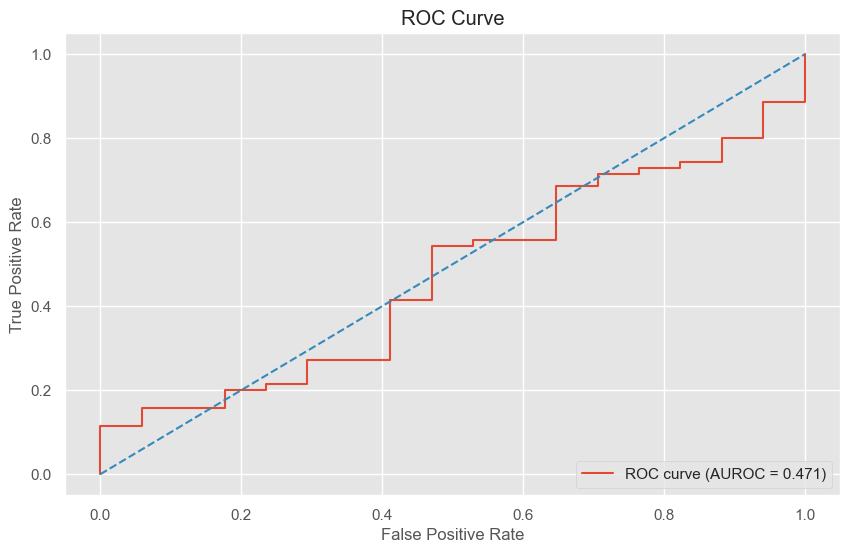

6. AUROC Value: 0.4714


In [13]:
from efficientnet_pytorch import EfficientNet
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(51)
torch.manual_seed(51)

# Data preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset
dataset_path = 'C:\\Users\\Zhongyao Wang\\Desktop\\complete_data'
dataset = datasets.ImageFolder(dataset_path, transform=preprocess)

# Split dataset
train_indices, val_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=dataset.targets)
train_dataset = Subset(dataset, indices=train_indices)
val_dataset = Subset(dataset, indices=val_indices)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Load EfficientNet model
model_name = 'efficientnet-b0' 
efficientnet = efficientnet = EfficientNet.from_name(model_name)
num_ftrs = efficientnet._fc.in_features
efficientnet._fc = nn.Linear(num_ftrs, 2)  # binary classification

if torch.cuda.is_available():
    efficientnet = efficientnet.cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientnet.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    efficientnet.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        outputs = efficientnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_dataloader)}')

print('Finished Training')

y_true, y_pred, y_scores = evaluate_model(efficientnet, val_dataloader)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_scores)

print(f'1. Accuracy: {accuracy:.4f}')
print(f'2. Precision: {precision:.4f}')
print(f'3. Recall: {recall:.4f}')
print(f'4. F1 Score: {f1:.4f}')

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_scores)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUROC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f'6. AUROC Value: {roc_auc:.4f}')